In [1]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import string,os
from  string  import  punctuation     
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.cluster import KMeans

In [2]:
# Read data
df = pd.read_csv('../data/clean_data/clean_data.csv')

In [3]:
## prerequisite
#python -m spacy download en_core_web_sm

# Data Preprocessing & Text Wrangling 

In [4]:
nlp = spacy.load('en_core_web_sm', vectors='en_google')
WNlemma = nltk.WordNetLemmatizer()
STOP_WORDS=stopwords.words("English")
custom_stopwords = [word for word in  open(os.path.join('util','custom_stopwords.txt'), "r").read().split() if word not in STOP_WORDS]
mystopwords = STOP_WORDS + custom_stopwords
def transform(text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r'''(?i)\b((?:http?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"dead", " death ", text)    
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub("[^a-zA-Z,]"," ",str(text))
    text = text.split(',')[0].lower()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    return text
def preprocess_nltk(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub("[^a-zA-Z]"," ", str(text))
    tokens = nltk.word_tokenize(text)
    tokens=[ WNlemma.lemmatize(t.lower()) for t in tokens]
    tokens_nop = [ t for t in tokens if t not in string.punctuation]
    tokens_lower=[t.lower() for t in tokens_nop]
    tokens_nostop=[ t for t in tokens_lower if t not in mystopwords]
    tokens_clean = [t for t in tokens_nostop if len(t) >=3]
    return(tokens_clean)
def preprocess_spacy(text, remove_stopwords=True, stem_words=False, punctuations=punctuation):
    # use spacy to do nlp process without parser and NER
    doc = nlp(text, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-'] # reduce inflectional forms
    tokens = [tok for tok in tokens if tok not in mystopwords and tok not in punctuations]
    text = ' '.join(tokens)
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    text=" ".join(text.split())
    return(tokens)
# generate wordcloud
def gen_wc(text,process_flag,title_txt):
    if process_flag:tokens_clean = preprocess_nltk(text)
    #if process_flag:tokens_clean = preprocess_spacy(text)
    else : tokens_clean = text
    fd_clean = nltk.FreqDist(tokens_clean)
    wc2 = WordCloud(background_color="white")
    wc2.generate_from_frequencies(fd_clean)
    plt.imshow(wc2, interpolation="bilinear")
    plt.title(title_txt)
    plt.axis("off")
    plt.show()
def print_terms(cm, num):
    original_space_centroids = svd.inverse_transform(cm.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(num):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()
dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5',
        6: '6'}
cluster_labels = [ dict[c] for c in range(6)]

## Subsample into 3 groups
    1) WPSG 
         3 clusters
    2) PAPSG 
         3 clusters
    3) Overall_SingaporeGeneralElection 
        5 clusters

In [5]:
cluster_grp1 ,cluster_grp2 ,cluster_grp3 = 3,3,5
df['Tag'] = df['Tag'].apply(transform) 
keys = df.Tag.value_counts().keys()
mystopwords = mystopwords + keys.tolist()
print('Stopwords count - default : {}, custom : {}, total :{}'.format(len(STOP_WORDS),len(custom_stopwords),len(mystopwords)))
df['Content'] = df['Content'].apply(transform)
df.Tag.value_counts()

Stopwords count - default : 179, custom : 341, total :534


singaporevotes                     2270
general election sg                2250
ge                                  963
general election sg                 956
sgelections                         762
sgelection                          569
ge    sg                            211
singapore general election          179
wpsg                                129
gesg                                117
singapore general election          101
singapore ge                         93
sgge                                 89
papsingapore                         81
Name: Tag, dtype: int64

Dataset (129, 9)


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['general_election_sg', 'general_election_sg2020', 'gesg', 'japan', 'singapore_general_election_2020'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Explained variance of the SVD step: 70%
Wall time: 15.6 ms
Silhouette Coefficient for clusters: 0.415
Cluster 0: opposition pritam jamus jamuslim singh istandwithraeesah khan raeesah covid makeyourvotecount
Cluster 1: low thia khiang dennis istandwithraeesah makeyourvotecount jamus keen battle leader
Cluster 2: resident edinburgh dennis stand makeyourvotecount leader pritam manifesto singh opposition


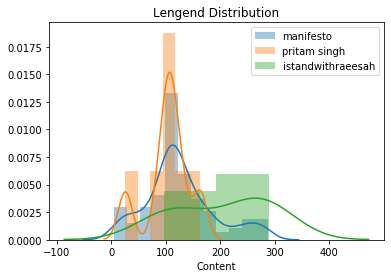

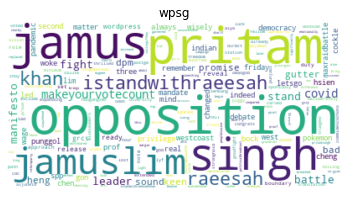

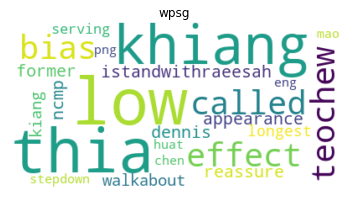

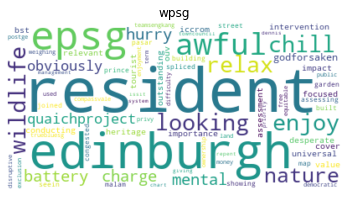

In [6]:
sel_df = df[(df['Tag']=='wpsg')]
print("Dataset {}".format(sel_df.shape))
num_cluster = cluster_grp1
text=sel_df['Content']
toks = text.apply(preprocess_nltk)
vectorizer = TfidfVectorizer(max_df=0.4, max_features=1500,
                             min_df=3, stop_words=mystopwords,use_idf=True)        
X_=[" ".join(token) for token in toks]
X=vectorizer.fit_transform(X_)  
svd = TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
        random_state=42, tol=0.0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
km = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=1000, n_init=1,random_state=4321)
%time km.fit(X_lsa)
labels = df['Tag']
print("Silhouette Coefficient for clusters: %0.3f"% metrics.silhouette_score(X_lsa, km.labels_))

print_terms(km, num_cluster)
cluster_labels = [ dict[c] for c in km.labels_]
sel_df['class']= cluster_labels

s1 = sel_df[sel_df['class'] == '0']['Content']
sns.distplot(s1.str.len(), label='manifesto')
s2 = sel_df[sel_df['class'] == '1']['Content']
sns.distplot(s2.str.len(), label='pritam singh')
s3 = sel_df[sel_df['class'] == '2']['Content']
sns.distplot(s3.str.len(), label='istandwithraeesah')

plt.title('Lengend Distribution')
plt.legend()
for i in range(1,num_cluster+1):
    plt.figure()
    gen_wc(' '.join(eval('s%d'%(i))),True,'wpsg')

Dataset (81, 9)
Explained variance of the SVD step: 81%
Wall time: 0 ns
Silhouette Coefficient for clusters: 0.351
Cluster 0: west bukit nsp pasir voice popularity chu kang slate help
Cluster 1: covid hand help fight nsp popularity opposition chu kang manifesto
Cluster 2: pm hsien manifesto slate covid fight bukit kang nsp pasir


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['general_election_sg', 'general_election_sg2020', 'gesg', 'japan', 'singapore_general_election_2020'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


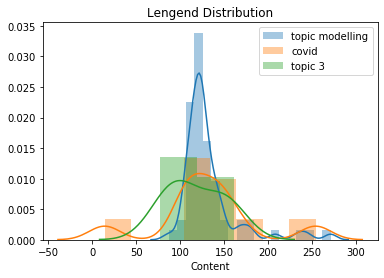

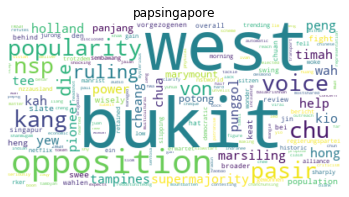

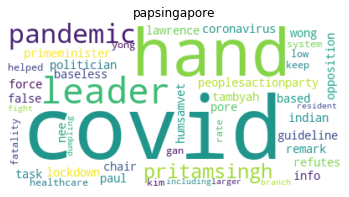

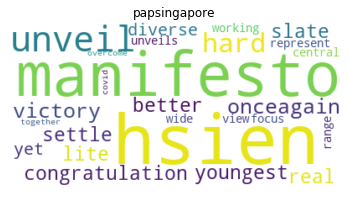

In [7]:
sel_df = df[(df['Tag']=='papsingapore')]
print("Dataset {}".format(sel_df.shape))

num_cluster = cluster_grp2
text=sel_df['Content']
toks = text.apply(preprocess_spacy)
vectorizer = TfidfVectorizer(max_df=0.4, max_features=1000,
                             min_df=3, stop_words=mystopwords,use_idf=True)        
X_=[" ".join(token) for token in toks]
X=vectorizer.fit_transform(X_)  
svd = TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
        random_state=42, tol=0.0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
lsa

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
km = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=1000, n_init=1,random_state=4321)
%time km.fit(X_lsa)
labels = df['Tag']
print("Silhouette Coefficient for clusters: %0.3f"
      % metrics.silhouette_score(X_lsa, km.labels_))

print_terms(km, num_cluster)
cluster_labels = [ dict[c] for c in km.labels_]
sel_df['class']= cluster_labels
#result.append(sel_df)

s1 = sel_df[sel_df['class'] == '0']['Content']
sns.distplot(s1.str.len(), label='topic modelling')
s2 = sel_df[sel_df['class'] == '1']['Content']
sns.distplot(s2.str.len(), label='covid')
s3 = sel_df[sel_df['class'] == '2']['Content']
sns.distplot(s3.str.len(), label='topic 3')

plt.title('Lengend Distribution')
plt.legend()
for i in range(1,num_cluster+1):
    plt.figure()
    gen_wc(' '.join(eval('s%d'%(i))),True,'papsingapore')

Dataset (8560, 9)


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['general_election_sg', 'general_election_sg2020', 'gesg', 'japan', 'singapore_general_election_2020'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Explained variance of the SVD step: 7%
Wall time: 0 ns
Silhouette Coefficient for clusters: 0.469
Cluster 0: sgvote noblankcheque singaporeans pm opposition lose votepapout go mps rule
Cluster 1: go singaporeans pm opposition covid hsien pandemic straitstime rule upcoming
Cluster 2: open upcoming station go hotly rule pm singaporeans friday cnbc
Cluster 3: pm hsien go opposition covid mandate decide dissolve straitstime pandemic
Cluster 4: rule majority power opposition hsien go pandemic covid singaporeans pm


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


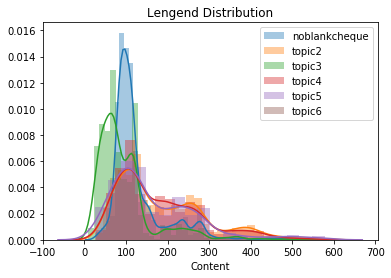

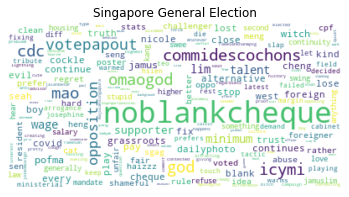

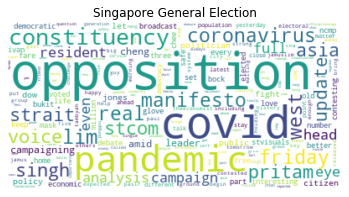

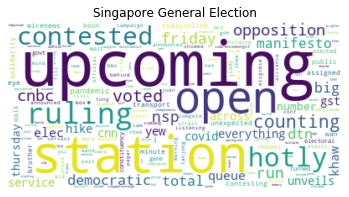

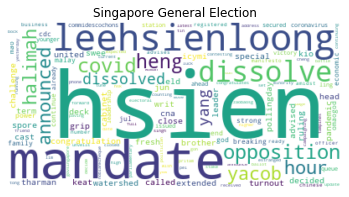

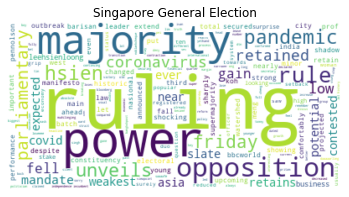

In [8]:
#for idx in range(len(keys)):
#    print(keys[idx])
num_cluster = cluster_grp3
sel_df = df[(df['Tag']!='wpsg') & (df['Tag']!='papsingapore')]
print("Dataset {}".format(sel_df.shape))
text=sel_df['Content']
toks = text.apply(preprocess_spacy)
vectorizer = TfidfVectorizer(max_df=0.4, max_features=2000,
                             min_df=3, stop_words=mystopwords,use_idf=True)        
X_=[" ".join(token) for token in toks]
X=vectorizer.fit_transform(X_)  
svd = TruncatedSVD(algorithm='randomized', n_components=6, n_iter=100,
        random_state=42, tol=0.0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
lsa

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
km = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=1000, n_init=1,random_state=4321)
%time km.fit(X_lsa)
labels = df['Tag']
print("Silhouette Coefficient for clusters: %0.3f"
      % metrics.silhouette_score(X_lsa, km.labels_))

print_terms(km, num_cluster)
cluster_labels = [ dict[c] for c in km.labels_]
sel_df['class']= cluster_labels
#result.append(sel_df)

s1 = sel_df[sel_df['class'] == '0']['Content']
sns.distplot(s1.str.len(), label='noblankcheque')
s2 = sel_df[sel_df['class'] == '1']['Content']
sns.distplot(s2.str.len(), label='topic2')
s3 = sel_df[sel_df['class'] == '2']['Content']
sns.distplot(s3.str.len(), label='topic3')
s4 = sel_df[sel_df['class'] == '3']['Content']
sns.distplot(s4.str.len(), label='topic4')
s5 = sel_df[sel_df['class'] == '4']['Content']
sns.distplot(s5.str.len(), label='topic5')
s6 = sel_df[sel_df['class'] == '5']['Content']
sns.distplot(s6.str.len(), label='topic6')

plt.title('Lengend Distribution')
plt.legend()
for i in range(1,num_cluster+1):
    plt.figure()
    gen_wc(' '.join(eval('s%d'%(i))),True,'Singapore General Election')